# Project: Multiple Regression Analysis for Beer Ratings

### Kate Grosch and Lucas Baker

We would like to determine whether factors such as ABV, reviewer age, and beer appearance contribute to the overall rating of a beer, using data from online craft beer ratings.

To begin our analysis, we will load the project packages and the dataset.

In [1]:
# loading the packages and modules

%matplotlib inline

# general packages
import numpy as np
import pandas as pd
import sklearn
import statsmodels.api as sm
from collections import defaultdict

# for statistics
import scipy.stats as stats
import statsmodels.api as sm

# for visualizations
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Important Notes about the Data

We do some basic data cleaning below: We remove ABV values outside of 3 standard deviations from the mean (to remove some junk ABV values we had) and we remove rows without a valid reviewer gender and age. 

In [2]:
#loading and cleaning the data

df = pd.read_csv("beer.csv")

df = df.rename(index=str, columns={'beer/ABV': 'ABV', 
                                   'user/gender':'gender', 
                                   'user/ageInSeconds':'reviewerAgeInSeconds', 
                                   'review/overall':'overall', 
                                   'beer/beerId':'beerId', 
                                   'beer/brewerId':'brewerId', 
                                   'review/appearance':'appearance', 
                                   'review/aroma':'aroma', 
                                   'review/palate':'palate', 
                                   'review/taste':'taste', 
                                   'review/timeUnix': 'unixPostTime'})

df = df[np.abs(df.ABV-df.ABV.mean()) <= (3*df.ABV.std())]
df = df[df.reviewerAgeInSeconds.notnull()]
df = df[df.gender.notnull()]

Y = df['overall']
df = df.drop(['review/text', 
              'review/timeStruct',
              'user/birthdayRaw',
              'user/birthdayUnix',
              'index',
              'beer/style', 
              'user/profileName'], axis=1)

df.describe()


,ABV,beerId,brewerId,appearance,aroma,overall,palate,taste,unixPostTime,reviewerAgeInSeconds
count,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7.704000e+03,7.704000e+03
mean,7.454991,21805.936397,3068.560618,3.912318,3.897326,3.912059,3.866498,3.952687,1.236645e+09,1.167445e+09
std,2.272365,18540.411751,5187.312029,0.590726,0.671394,0.698766,0.668260,0.714050,6.573249e+07,3.088040e+08
min,0.500000,175.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.932515e+08,7.034366e+08
25%,5.500000,5441.000000,395.000000,3.500000,3.500000,3.500000,3.500000,3.500000,1.198043e+09,9.775586e+08
50%,7.000000,18968.000000,1199.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.248133e+09,1.096639e+09
75%,9.400000,34146.000000,1315.000000,4.500000,4.500000,4.500000,4.500000,4.500000,1.289380e+09,1.274541e+09
max,14.000000,77207.000000,26990.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.326257e+09,3.594723e+09


### Model and Variables

Our full list of variables is ABV, brewer, appearance rating, aroma rating, palate rating, taste rating, review submission date, reviewer age, and reviewer gender. We got this dataset from Kaggle, and the CSV is available at https://github.com/katiegrosch/beer-data-analysis.

Before performing the analysis, we will preprocess the data to extract our explanatory features. Our desired y and x<sub>i</sub>'s are as follows:

y: Overall rating, on a range of [1.0, 5.0]. <br>
x<sub>1</sub> The number of reviews for the beer. <br>
x<sub>2</sub> Average reviewer age. <br>
x<sub>3</sub> Fraction of female reviewers. <br>
x<sub>4</sub> Beer appearance rating, in the range [1.0, 5.0]. <br>
x<sub>5</sub> Alcohol by volume. <br>
x<sub>6</sub> Length of beer name. <br>

We will be modeling the impact of the x<sub>i</sub>'s on y in the form of the following multiple regression model, where &beta;<sub>i</sub>'s are constants fit by least squares regression:<br><br>
y = &beta;<sub>0</sub> + &beta;<sub>1</sub>x<sub>1</sub> + &beta;<sub>2</sub>x<sub>2</sub> + &beta;<sub>3</sub>x<sub>3</sub> + &beta;<sub>4</sub>x<sub>4</sub> + &beta;<sub>5</sub>x<sub>5</sub> + &beta;<sub>6</sub>x<sub>6</sub>

Let's reshape and group the data by beer:

In [3]:
df['beerNameLength'] = pd.Series([len(x) for x in df['beer/name']], index=df.index)

beer_abv = dict()
beer_overall = defaultdict(list)
beer_appearance = defaultdict(list)
reviewer_ages = defaultdict(list)
reviewer_genders = defaultdict(list)
for index, row in df.iterrows():
    name = row['beer/name']
    beer_abv[name] = row['ABV']  # Will overwrite, but same values
    beer_overall[name].append(row['overall'])
    beer_appearance[name].append(row['appearance'])
    reviewer_ages[name].append(row['reviewerAgeInSeconds'])
    reviewer_genders[name].append(0.0 if row['gender'].startswith("M") else 1.0)
names = sorted(set(df['beer/name']))
    
combined = {
    'beerName': names,
    'numReviews': [len(beer_overall[name]) for name in names],
    'ABV': [beer_abv[name] for name in names],
    'avgAppearance': [np.mean(beer_appearance[name]) for name in names],
    'avgReviewerAgeInYears': [np.mean(reviewer_ages[name]) / 31557600 for name in names],
    'fractionFemale': [np.mean(reviewer_genders[name]) for name in names],
    'beerNameLength': [len(name) for name in names],
    'avgOverall': [np.mean(beer_overall[name]) for name in names]
}

# Save for later
original = df.drop(['beerId', 
                    'brewerId',
                    'unixPostTime',
                    'reviewerAgeInSeconds',
                    'gender'
                   ], axis=1)
df = pd.DataFrame(combined)
df.describe()

,numReviews,ABV,avgAppearance,avgReviewerAgeInYears,fractionFemale,beerNameLength,avgOverall
count,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,10.123522,6.331905,3.678017,37.858362,0.011464,19.498029,3.676361
std,31.617209,1.984198,0.542341,8.498555,0.082130,9.081810,0.674804
min,1.000000,0.500000,1.000000,25.104959,0.000000,2.000000,1.000000
25%,1.000000,5.000000,3.500000,33.565032,0.000000,13.000000,3.500000
50%,2.000000,5.800000,3.762500,36.731424,0.000000,18.000000,3.825000
75%,5.000000,7.500000,4.000000,40.583455,0.000000,25.000000,4.000000
max,408.000000,14.000000,5.000000,113.488258,1.000000,72.000000,5.000000


To begin our analysis, let's look at a graph of every x<sub>i</sub> versus our target variable (overall rating).

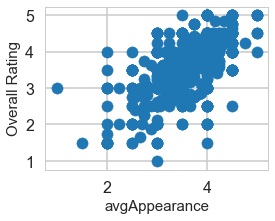

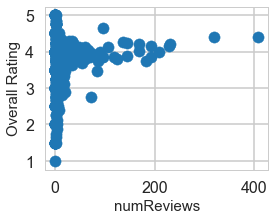

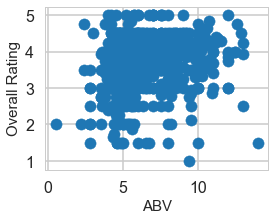

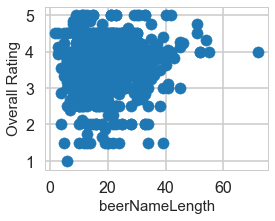

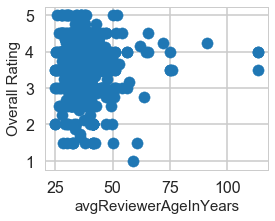

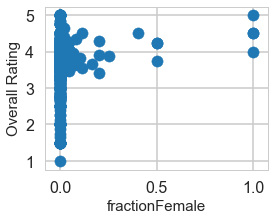

In [4]:
Y = df['avgOverall']
ratings = df.drop(['avgOverall', 'beerName'], axis=1)

for column in ['avgAppearance', 'numReviews', 'ABV', 'beerNameLength', 'avgReviewerAgeInYears', 'fractionFemale']:
    plt.figure(figsize=(4, 3))
    plt.scatter(ratings[column], Y)
    plt.ylabel('Overall Rating', size=15)
    plt.xlabel(column, size=15)

### Variable Correlations

Visually speaking, there appears to be a strong correlation between appearance rating and overall rating, as might be expected. Number of reviews also appears at least somewhat linked to quality: while there are many beers with few reviews at all levels, the most frequently reviewed beers are rated above 4.0, relative to a mean average overall rating of 3.67. The other explanatory variables seem to have a more tenuous connection. Plots for ABV, beer name length, and average reviewer age in years appear as a fairly undifferentiated mass, and while it is clear that female reviewers give a higher rating on average, the average fraction of female viewers is 1.1%! Detecting a strong effect on such a lopsided distribution may be difficult.

Let's also see if any of the variables correlate with each other. If we encounter multicollinearity, it may make sense to remove one of the correlated variables:

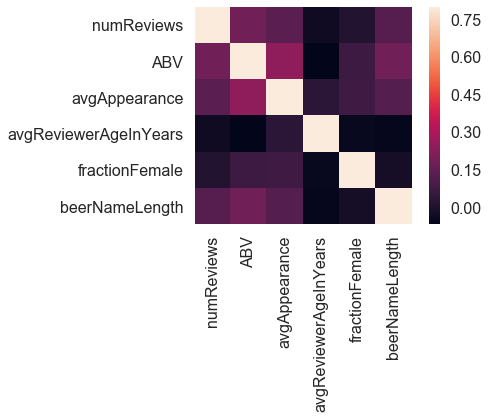

In [5]:
corrmat = ratings.corr()
sns.heatmap(corrmat, vmax=.8, square=True);

### Variable correlations in the heatmap

In the confusion matrix above, lighter colors imply higher correlation. Trivially, each variable has a perfect correlation with itself. We can confirm that none of these variables correlate strongly with one another, which is reasonable given the idiosyncratic selection. However, ABV and appearance rating show at least a weak relationship, which may suggest a correlation between ABV, appearance, and a third variable such as style. (For example, an Imperial Stout might tend to be both stronger and darker in color.)

Before we create our regression model, let's look at a histogram of the ratings to get a sense of where they cluster. It looks like the ratings are left-skewed, but overall have a near-normal distribution. We confirm by calculating the skew of the data to be -0.9947, which might affect our model.

Skew: -0.994747


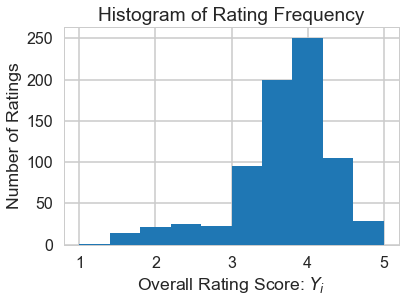

In [6]:
plt.hist(Y)
plt.xlabel("Overall Rating Score: $Y_i$")
plt.ylabel("Number of Ratings")
plt.title("Histogram of Rating Frequency")

print("Skew: %f" % Y.skew())

### Building the Linear Regression

Text(0.5,1,'Ratings vs Predicted ratings: $Y_i$ vs $\\hat{Y}_i$')

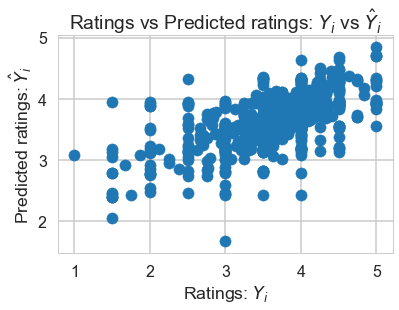

In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr = lr.fit(ratings, Y)
y_pred = lr.predict(ratings)

plt.scatter(Y, y_pred)
plt.xlabel("Ratings: $Y_i$")
plt.ylabel("Predicted ratings: $\hat{Y}_i$")
plt.title("Ratings vs Predicted ratings: $Y_i$ vs $\hat{Y}_i$")

In [8]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y, y_pred)
print("Mean Squared Error: %f" % mse)

Mean Squared Error: 0.281237


The variance of the estimator &sigma;<sup>2</sup> is close to MSE, but takes into account the degrees of freedom lost by the 6 regressors and the intercept:

In [9]:
print("Variance of error: SSE / (n - (k + 1)) = ", mse * len(Y) / (len(Y) - 7))

Variance of error: SSE / (n - (k + 1)) =  0.2838478759751049


In [10]:
print("Beta coefficients: ")
print(lr.coef_)
print("Largest coefficient: %f" % np.amax(lr.coef_))
print("R-squared: %f" % sklearn.metrics.r2_score(Y, y_pred))

Beta coefficients: 
[ 5.47086138e-04  3.12466676e-03  7.50137549e-01 -4.54447681e-03
  5.45879349e-01 -9.06856782e-04]
Largest coefficient: 0.750138
R-squared: 0.381573


The R-squared value is disappointingly low, but not so low as to suggest that our predictors are useless. Does the model have any significant variables?

The time has come to calculate confidence intervals, but remarkably, scikit-learn does not provide a built-in method of accessing model statistics. Let's switch to statsmodel, which does. The scikit model will provide a reference by which to confirm our numbers. (This sanity check is quite valuable: for instance, if the intercept is not explicitly added in statsmodel, it will not be included and the resulting R-squared will be unreasonably high.)

                            OLS Regression Results                            
Dep. Variable:             avgOverall   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     77.54
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           2.18e-75
Time:                        18:20:49   Log-Likelihood:                -597.13
No. Observations:                 761   AIC:                             1208.
Df Residuals:                     754   BIC:                             1241.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
numReviews                0.00

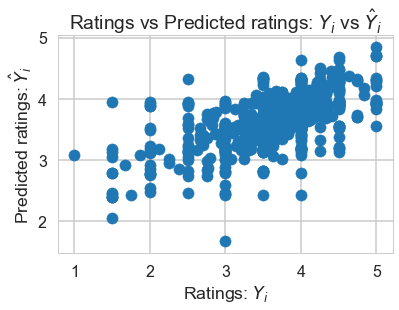

In [11]:
ratings['intercept'] = np.ones(len(ratings))
reg = sm.OLS(Y, ratings).fit()
y_pred = reg.predict(ratings)

plt.scatter(Y, y_pred)
plt.xlabel("Ratings: $Y_i$")
plt.ylabel("Predicted ratings: $\hat{Y}_i$")
plt.title("Ratings vs Predicted ratings: $Y_i$ vs $\hat{Y}_i$")

print(reg.summary())

As shown, the 95% (&alpha; = .05) confidence intervals for the regressors are as follows:

CI(&beta;<sub>intercept</sub>, &alpha; = .05) = [0.756, 1.395] <br>
CI(&beta;<sub>numReviews</sub>, .05) = [-0.001, 0.002] <br>
CI(&beta;<sub>ABV</sub>, .05) = [-0.017, 0.023] <br>
CI(&beta;<sub>avgAppearance</sub>, .05) = [0.677, 0.823] <br>
CI(&beta;<sub>avgReviewerAgeInYears</sub>, .05) = [-0.009, -5.25e-05] <br>
CI(&beta;<sub>fractionFemale</sub>, .05) = [0.081, 1.011] <br>
CI(&beta;<sub>beerNameLength</sub>, .05) = [-0.005, 0.003] <br>

A one-star increase in appearance rating, all else equal, produces an extra .75 stars in overall rating. Women also rate just over half a star higher, and older reviewers about 1/200th of a star lower per year. All three of these variables are significant at the &alpha; = .05 level, even the reviewer age, which is an excellent demonstration of the distinction between significance and effect size. The other three variables (name length, number of reviews, and ABV) have high p-values, are not significant, and bear little apparent relation to overall rating.

The F-statistic of the model is 77.54, well over the critical value, as suggested by the F-test p-value of 2.18e-75. Thus, despite the quirky choice of variables, the resulting model is clearly significant.

Having evaluated the significance of all regressors, we will leave in appearance rating, fraction of female reviewers, and average reviewer age while removing the others to build the final model.

                            OLS Regression Results                            
Dep. Variable:             avgOverall   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     155.1
Date:                Sun, 12 Aug 2018   Prob (F-statistic):           2.28e-78
Time:                        18:20:49   Log-Likelihood:                -597.64
No. Observations:                 761   AIC:                             1203.
Df Residuals:                     757   BIC:                             1222.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
avgAppearance             0.75

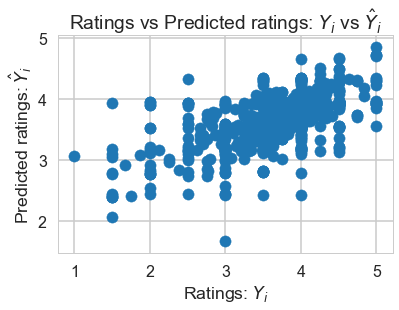

In [12]:
ratings_final = ratings.drop(['numReviews', 'ABV', 'beerNameLength'], axis=1)
reg_final = sm.OLS(Y, ratings_final).fit()
y_pred_final = reg_final.predict(ratings_final)

plt.scatter(Y, y_pred_final)
plt.xlabel("Ratings: $Y_i$")
plt.ylabel("Predicted ratings: $\hat{Y}_i$")
plt.title("Ratings vs Predicted ratings: $Y_i$ vs $\hat{Y}_i$")

print(reg_final.summary())

In the new model, the F-statistic has roughly doubled (155.1 vs 77.54) and the p-value dropped by a factor of 1000 (2.28e-78 vs 2.18e-75), while the adjusted R-squared has also increased slightly (0.378 vs 0.377). The raw R-squared has decreased slightly (0.381 to 0.382), but this is to be expected because additional regressors can only increase the R-squared value. From the rise in adjusted R-squared and F-statistic values, we may conclude that the new model with fewer variables is superior.

Looking back, does the error in our data fit the Gaussian assumptions of a normal, zero-mean, constant variance random variable? Earlier, we calculated the skew to be -0.9947, so the ratings themselves are not quite normally distributed. However, multiple linear regression can still work effectively if the residuals are near-random.

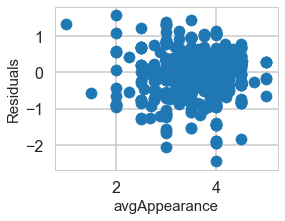

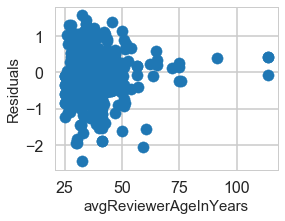

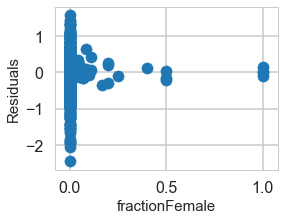

In [13]:
for column in ['avgAppearance', 'avgReviewerAgeInYears', 'fractionFemale']:
    plt.figure(figsize=(4, 3))
    plt.scatter(ratings_final[column], Y - y_pred_final)
    plt.ylabel('Residuals', size=15)
    plt.xlabel(column, size=15)

The distribution of the data is not ideal, as we would much prefer to see an even spread of values along the x-axis. However, there is no clear evidence of heteroscedasticity, nonlinear patterns, or serious outliers.

There does appear to be a slight asymmetry across the x-axis, where many of the negative residuals have higher magnitudes than the positive ones. This imbalance reflects the skew in the initial distribution, where ratings are generally clustered around the 3-4 star range and rarely fall below. Since ratings are bounded at 1.0 and 5.0, there is more room for error by predicting too low than too high. Interpreting this asymmetry is a judgment call, but there is nothing here to suggest that the data would be better served by something other than a linear model.

## Discussion

Our project aimed to investigate how well multiple linear regression can predict overall beer rating based on the six features selected. We report that our selection of variables predicts overall rating with significance, but with low precision. One variable, average appearance rating, correlated extremely well with overall rating, while the fraction of female reviewers and average reviewer age also proved significant at the &alpha; = .05 level. The other three variables, ABV, beer name length, and number of reviews, showed no significant predictive ability. Our final model predicted overall rating from appearance rating, fraction of female reviewers, and average reviewer age with an R-squared of 0.381 and adjusted R-squared of 0.378, an F-statistic of 155.1 with p-value of 2.28e-78, and p-values of 0.000, 0.019, 0.043, respectively, for the three regressors. While our original data exhibited skew that led to a somewhat asymmetric residual distribution, there was no observed heteroscedasticity, nonlinear patterns, or serious outliers that would argue against the selection of a linear model. 

Overall, the above investigation serves as a good illustration of the difference between significance and usefulness. The relationships identified by regression were certainly significant, but if model effectiveness were a priority, the most desirable option would be to gather more predictive data. For example, the pure rating data is more predictive than our derived features, with an adjusted R-squared of 0.629 even before aggregation:

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     3262.
Date:                Sun, 12 Aug 2018   Prob (F-statistic):               0.00
Time:                        18:20:50   Log-Likelihood:                -4351.4
No. Observations:                7704   AIC:                             8713.
Df Residuals:                    7699   BIC:                             8748.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
appearance     0.0349      0.010      3.405      0.0

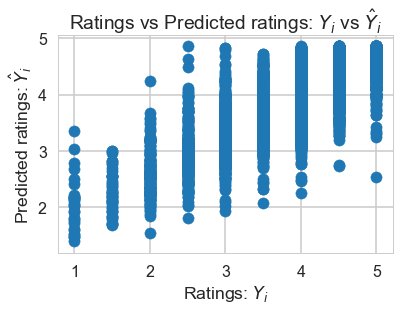

In [14]:
original['intercept'] = np.ones(len(original))
original_ratings = original[['appearance', 'aroma', 'palate', 'taste', 'intercept']]
original_Y = original['overall']
reg_original = sm.OLS(original_Y, original_ratings).fit()
y_pred_original = reg_original.predict(original_ratings)

plt.scatter(original_Y, y_pred_original)
plt.xlabel("Ratings: $Y_i$")
plt.ylabel("Predicted ratings: $\hat{Y}_i$")
plt.title("Ratings vs Predicted ratings: $Y_i$ vs $\hat{Y}_i$")

print(reg_original.summary())

Sometimes one finds fascinating relationships in data sources that do not initially appear connected, and this is the type of data science journalists love to write stories about. The rest of the time, however, the data that looks connected is and that which doesn't isn't. Nonetheless, we have learned at least one non-obvious lesson: all else being equal, young women appear to look more kindly on the beer they drink.